In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans

import requests

# Folium library

We'll be using Folium, a mapping library. You may need to run the following cell (after un-commenting it) and restart the kernel.

In [2]:
#!pip install --user folium

In [3]:
import folium


# Capital Bikeshare Rides Data

In [4]:
# Replace "ROOT" with where you've downloaded the data.
#ROOT = "/home/cs/data202/CaptialBikeShare/"
ROOT = '../data/capital_bikeshare/'
rides = pd.concat([
    pd.read_csv(
        f"{ROOT}/2019{month:02d}-capitalbikeshare-tripdata.zip",
    usecols=["Duration", "Start date", "End date", "Start station number", "End station number", "Member type"])
    for month in range(1, 11)
])
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3013027 entries, 0 to 337551
Data columns (total 6 columns):
Duration                int64
Start date              object
End date                object
Start station number    int64
End station number      int64
Member type             object
dtypes: int64(3), object(3)
memory usage: 160.9+ MB


In [5]:
print('{:,d}'.format(len(rides)))
rides.head()

3,013,027


,Duration,Start date,End date,Start station number,End station number,Member type
0,230,2019-01-01 00:04:48,2019-01-01 00:08:39,31203,31200,Member
1,1549,2019-01-01 00:06:37,2019-01-01 00:32:27,31321,31114,Casual
2,177,2019-01-01 00:08:46,2019-01-01 00:11:44,31104,31323,Casual
3,228,2019-01-01 00:08:47,2019-01-01 00:12:35,31281,31280,Member
4,1300,2019-01-01 00:12:29,2019-01-01 00:34:10,31014,31923,Member


In [6]:
rides['start_datetime'] = pd.to_datetime(rides['Start date'])
rides['start_date'] = rides['start_datetime'].dt.date
rides['start_month'] = rides['start_datetime'].dt.month
rides['start_hour'] = rides['start_datetime'].dt.hour

# Station Data
Let's get the [info about each station](https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json).

Main things to notice in this section:

* **JSON is a useful format for structured data**.
* The `requests` library is a relatively easy way to automatically fetch data from the Web
* Pandas can make a DataFrame from a list of `dict`s.

In [7]:
station_info_response = requests.get("https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json")
station_info_response_json = station_info_response.json()

In [8]:
stations = pd.DataFrame(station_info_response_json['data']['stations'])

In [9]:
print(len(stations), 'stations')
stations.head()

574 stations


,capacity,eightd_has_key_dispenser,eightd_station_services,electric_bike_surcharge_waiver,external_id,has_kiosk,lat,lon,name,region_id,rental_methods,rental_url,short_name,station_id
0,19,False,[{'id': '5029b3a1-a049-46f9-a13c-c7ffef2bb88c'...,False,08249be7-1f3f-11e7-bf6b-3863bb334450,True,38.902221,-77.059219,Georgetown Harbor / 30th St NW,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31215,72
1,23,False,[{'id': '6944e559-dc16-4a55-9125-e2c3256e294e'...,False,0824aa39-1f3f-11e7-bf6b-3863bb334450,True,38.900283,-77.029822,13th St & New York Ave NW,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31227,91
2,35,False,[{'id': '2a0089f1-ce95-4633-9471-61b0f70b7c08'...,False,0824c80d-1f3f-11e7-bf6b-3863bb334450,True,38.902061,-77.038322,17th & K St NW / Farragut Square,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31233,106
3,15,False,NaN,False,082469cc-1f3f-11e7-bf6b-3863bb334450,True,38.858971,-77.053230,Eads St & 15th St S,41,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31000,1
4,11,False,NaN,False,08246b69-1f3f-11e7-bf6b-3863bb334450,True,38.857250,-77.053320,18th St & S Eads St,41,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31001,2


In [10]:
# Use the "short name" as the index, to make sure our data processing results line up.
stations['short_name'] = pd.to_numeric(stations['short_name'])
stations = stations.set_index('short_name')

In [11]:
# Use a subset of columns
stations = stations[['name', 'lat', 'lon', 'capacity', 'region_id']]
stations.head()

,name,lat,lon,capacity,region_id
short_name,,,,,
31215,Georgetown Harbor / 30th St NW,38.902221,-77.059219,19,42
31227,13th St & New York Ave NW,38.900283,-77.029822,23,42
31233,17th & K St NW / Farragut Square,38.902061,-77.038322,35,42
31000,Eads St & 15th St S,38.858971,-77.053230,15,41
31001,18th St & S Eads St,38.857250,-77.053320,11,41


Stations have a *capacity*, which is probably the number of bikes that can be parked there.

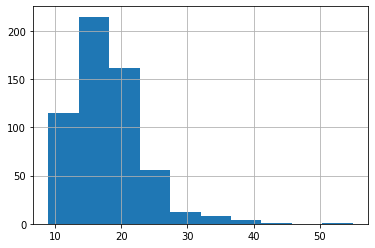

In [12]:
stations.capacity.hist()

# Adding traffic data

We need to make sure to only use rides for stations we know the locations of, or we'll be fighting with missing values below.

In [13]:
missing_stations = set(rides['Start station number']) - set(stations.index)
missing_stations

{31008, 32031, 32051}

In [14]:
rides_filt = rides[~rides['Start station number'].isin(missing_stations)]

Collect hourly ride patterns: total number of rides each hour of the day.

In [15]:
hourly_ride_patterns = (
    rides_filt
    .groupby(['Start station number', 'start_hour'])
    .size().unstack(1)
    .fillna(0)
)

print(hourly_ride_patterns.shape)
hourly_ride_patterns.head()

(572, 24)


start_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Start station number,,,,,,,,,,,,,,,,,,,,,
31000,25.0,4.0,0.0,0.0,2.0,8.0,13.0,47.0,68.0,156.0,...,81.0,64.0,70.0,102.0,146.0,117.0,64.0,50.0,13.0,9.0
31001,9.0,6.0,2.0,0.0,0.0,23.0,8.0,37.0,136.0,96.0,...,90.0,71.0,113.0,194.0,239.0,147.0,82.0,74.0,41.0,31.0
31002,11.0,16.0,0.0,0.0,1.0,3.0,62.0,250.0,553.0,283.0,...,226.0,256.0,440.0,768.0,588.0,371.0,175.0,70.0,57.0,40.0
31003,8.0,11.0,13.0,3.0,2.0,5.0,120.0,111.0,229.0,231.0,...,154.0,252.0,492.0,501.0,348.0,252.0,188.0,79.0,48.0,37.0
31004,3.0,2.0,0.0,0.0,1.0,10.0,109.0,220.0,217.0,186.0,...,82.0,101.0,130.0,165.0,132.0,97.0,62.0,18.0,5.0,9.0


Make sure the indices match between the hourly ride data and the station data. Notice that now the stations are sorted (beacuse the grouping operation above sorted the groups). This will be important when we make predictions about `stations` based on data in `hourly_ride_patterns` -- we need to make sure that the rows line up!

In [16]:
stations_aligned = stations.reindex(index=hourly_ride_patterns.index)
print(len(stations_aligned))
stations_aligned.head()

572


,name,lat,lon,capacity,region_id
Start station number,,,,,
31000,Eads St & 15th St S,38.858971,-77.053230,15,41
31001,18th St & S Eads St,38.857250,-77.053320,11,41
31002,Crystal Dr & 20th St S,38.856425,-77.049232,17,41
31003,Crystal Dr & 15th St S,38.860170,-77.049593,11,41
31004,Aurora Hills Cmty Ctr / 18th St & S Hayes St,38.857866,-77.059490,11,41


# Pick colors

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

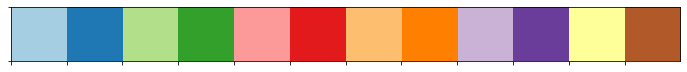

In [17]:
colors = sns.color_palette("Paired")
sns.palplot(colors)
color_codes = colors.as_hex()
color_codes

# Cluster

Let's make a few different types of clusterings:

1. By geographic location (2 dimensions)
2. By geographic location and capacity (3 dimensions)
3. By hourly activity (24 dimensions)

They all work the same way: we construct a table (technically a matrix) of features for each station, then use it to `fit` a cluster-er.

## 1. By geographic location

First, construct the feature matrix. (Try changing these scaling factors!)

In [18]:
X = np.c_[
    1.0 * stations_aligned['lat'],
    1.0 * stations_aligned['lon']
]
print(X.shape)

(572, 2)


Fit a clusterer.

In [19]:
km = KMeans(n_clusters=8)  # Try changing n_clusters!
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

"Predict" the cluster memberships.

In [20]:
stations_aligned['kmeans_cluster'] = km.predict(X)

Make a map.

In [21]:
cluster_to_color = dict(enumerate(color_codes.copy()))

def show_stations_on_map(stations_df):
    m = folium.Map(
        location=[39, -77.],
        tiles='Stamen Toner',
        zoom_start=10
    )

    for station in stations_df.itertuples():
        folium.CircleMarker(
            location=[station.lat, station.lon],
            tooltip=f"{station.name}, capacity={station.capacity}",
            color=cluster_to_color[station.kmeans_cluster],
            radius=2
        ).add_to(m)
    return m

show_stations_on_map(stations_aligned)

## 2. By geographic location and capacity (3 dimensions)

In [22]:
# Again, try changing these weights, especially the relative weight between capacity and geography.
X = np.c_[
    1.0 * stations_aligned['lat'],
    1.0 * stations_aligned['lon'],
    1.0 * stations_aligned['capacity']
]
print(X.shape)

(572, 3)


Fit a clusterer.

In [23]:
km = KMeans(n_clusters=8)  # Try changing n_clusters!
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

"Predict" the cluster memberships.

In [24]:
stations_aligned['kmeans_cluster'] = km.predict(X)

Make a map.

In [25]:
show_stations_on_map(stations_aligned)

## 3. By hourly activity (24 dimensions)

In [26]:
X = hourly_ride_patterns.values
print(X.shape)

(572, 24)


Fit a clusterer.

In [27]:
km = KMeans(n_clusters=8)  # Try changing n_clusters!
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

"Predict" the cluster memberships.

In [28]:
stations_aligned['kmeans_cluster'] = km.predict(X)

Make a map.

In [29]:
show_stations_on_map(stations_aligned)

Notice that now all of the suburban stations look similar, and the clusters seem to separate *meaningful* regions of downtown (with some exceptions).

More analysis of this data might want to include arrivals in addition to departures, and also perhaps break down the traffic pattern by working vs non-working days or other features.